In [3]:
import os
import pandas as pd
from glob import glob
import rioxarray as rxr
import geopandas as gpd
from sklearn.metrics import r2_score

import seaborn as sns
import matplotlib.pyplot as plt

---------------

`This script plots rainfed cropET values for major crop types in three regions of the HPA (Kansas, Texas, and Nebraska). The analysis helps visulization of why effective precipitation training data was sampled from the pasture croplands over the Western US. The reason is - ET from rainfed p[asture and other crop types have similar distribution. Over the entire Western US, rainfed cropland (pure crop, not pasture) was not available in all regions but rainfed pasture was. So, by taking effective precipitation training data from rainfed pasture, we were able to ensure that the training data is representative of the entire Western US.`

--------

In [6]:
# USDA CDL crop classification
USDA_cdl_class_df = pd.read_csv('../../Data_main/Data_Drivers_of_ET/USDA_cdl_classification.csv')
USDA_cdl_class_df = USDA_cdl_class_df.set_index(keys='Class')
# USDA_cdl_class_df.head()

# making the df to a dictionary
usda_cdl_dict = USDA_cdl_class_df.to_dict()
usda_cdl_dict = usda_cdl_dict['Crop']
usda_cdl_dict

{1: 'Corn',
 2: 'Cotton',
 3: 'Rice',
 4: 'Sorghum',
 5: 'Soybeans',
 6: 'Sunflower',
 10: 'Peanuts',
 11: 'Tobacco',
 12: 'Sweet Corn',
 13: 'Pop or Orn Corn',
 14: 'Mint',
 21: 'Barley',
 22: 'Durum Wheat',
 23: 'Spring Wheat',
 24: 'Winter Wheat',
 25: 'Other Small Grains',
 26: 'Dbl Crop WinWht/Soybeans',
 27: 'Rye',
 28: 'Oats',
 29: 'Millet',
 30: 'Speltz',
 31: 'Canola',
 32: 'Flaxseed',
 33: 'Safflower',
 34: 'Rape Seed',
 35: 'Mustard',
 36: 'Alfalfa',
 37: 'Other Hay/Non Alfalfa',
 38: 'Camelina',
 39: 'Buckwheat',
 41: 'Sugarbeets',
 42: 'Dry Beans',
 43: 'Potatoes',
 44: 'Other Crops',
 45: 'Sugarcane',
 46: 'Sweet Potatoes',
 47: 'Misc Vegs & Fruits',
 48: 'Watermelons',
 49: 'Onions',
 50: 'Cucumbers',
 51: 'Chick Peas',
 52: 'Lentils',
 53: 'Peas',
 54: 'Tomatoes',
 55: 'Caneberries',
 56: 'Hops',
 57: 'Herbs',
 58: 'Clover/Wildflowers',
 59: 'Sod/Grass Seed',
 60: 'Switchgrass',
 61: 'Fallow/Idle Cropland',
 63: 'Forest',
 64: 'Shrubland',
 65: 'Barren',
 66: 'Cherries'

In [6]:
# loading annual rainfed cropET data for KS, NE, and TX
ks_df = pd.read_csv('../../Data_main/results_eval/rainfed_cropET_compare/KS/KS_cropET.csv')
ne_df = pd.read_csv('../../Data_main/results_eval/rainfed_cropET_compare/NE/NE_cropET.csv')
tx_df = pd.read_csv('../../Data_main/results_eval/rainfed_cropET_compare/TX/TX_cropET.csv')

# Making a new colum with crop name in each dataset
ks_df['Crop'] = ks_df['USDA_CDL'].apply(lambda x: usda_cdl_dict[int(x)])
ne_df['Crop'] = ne_df['USDA_CDL'].apply(lambda x: usda_cdl_dict[int(x)])
tx_df['Crop'] = tx_df['USDA_CDL'].apply(lambda x: usda_cdl_dict[int(x)])

In [7]:
# Filtering the datasets from major crop types in each region and rrainfed cropland
ks_df_fil = ks_df[(ks_df['Crop'].isin(['Corn', 'Winter Wheat', 'Sorghum', 'Alfalfa', 'Soybeans', 'Pasture/Grassland'])) & 
                  (ks_df['Rainfed'] == 1)]
ne_df_fil = ne_df[(ne_df['Crop'].isin(['Corn', 'Winter Wheat', 'Alfalfa', 'Soybeans', 'Pasture/Grassland'])) & 
                  (ne_df['Rainfed'] == 1)]
tx_df_fil = tx_df[(tx_df['Crop'].isin(['Corn', 'Cotton', 'Winter Wheat', 'Sorghum', 'Pasture/Grassland'])) & 
                  (tx_df['Rainfed'] == 1)]

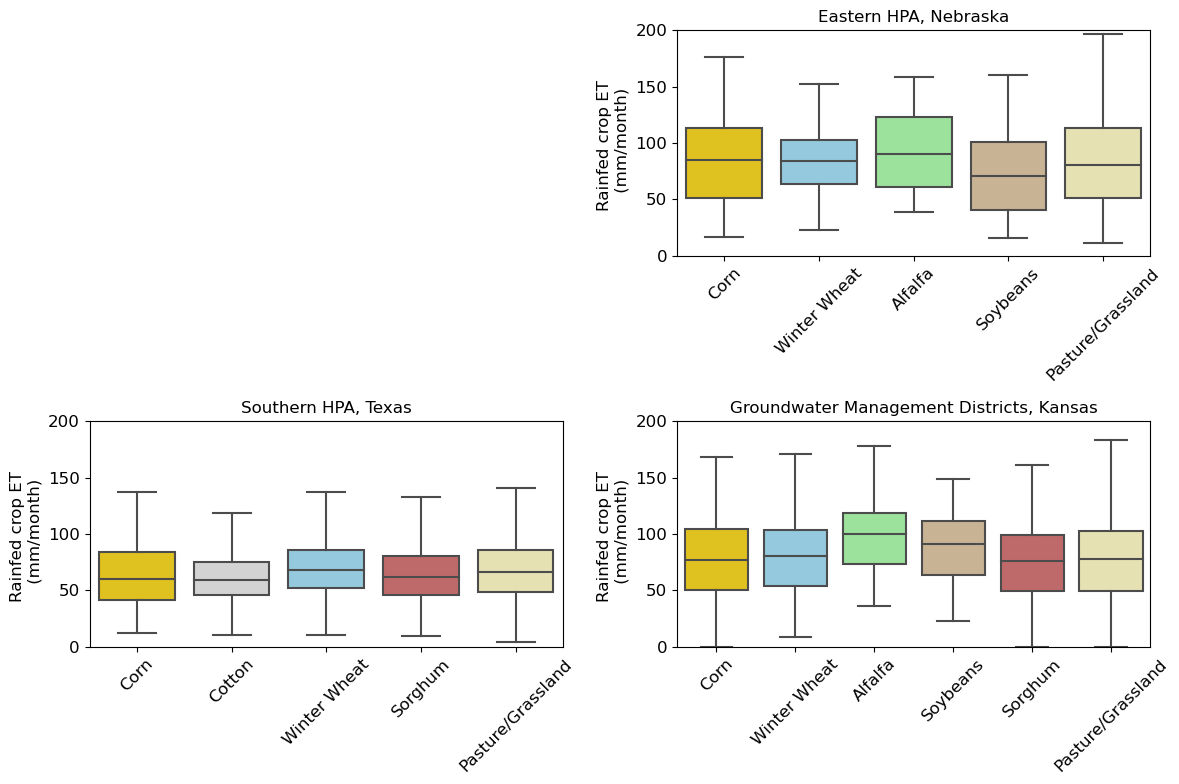

In [8]:
# Plotting major irrigated and rainfed crops' yearly irrigated and rainfed cropET
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

plt.rcParams['font.size'] = '12'

# setting similar color palette for similar crops 
category_colors = {'Corn': 'gold', 'Winter Wheat': 'skyblue', 'Sorghum': 'indianred', 'Alfalfa': 'lightgreen', 
                    'Cotton': 'lightgrey', 'Soybeans': 'tan', 'Pasture/Grassland': 'palegoldenrod'}

# category order
category_order_ks = ['Corn', 'Winter Wheat', 'Alfalfa', 'Soybeans', 'Sorghum', 'Pasture/Grassland']
category_order_ne = ['Corn', 'Winter Wheat', 'Alfalfa', 'Soybeans', 'Pasture/Grassland']
category_order_tx = ['Corn', 'Cotton', 'Winter Wheat', 'Sorghum', 'Pasture/Grassland']

# turning off the empyt plot at [1, 0] location
ax[0, 0].set_axis_off()

# NE
sns.boxplot(x=ne_df_fil['Crop'], y=ne_df_fil['Rainfed_cropET'], ax=ax[0, 1], 
            palette=category_colors, order=category_order_ne, showfliers=False)
ax[0, 1].set_ylabel('Rainfed crop ET \n (mm/month)', fontsize=12)
ax[0, 1].set_xlabel(None)
ax[0, 1].set_xticklabels(category_order_ne, rotation=45)
ax[0, 1].set_title('Eastern HPA, Nebraska', fontsize=12)
ax[0, 1].set_ylim([0, 200])

# KS
sns.boxplot(x=ks_df_fil['Crop'], y=ks_df_fil['Rainfed_cropET'], ax=ax[1, 1], 
            palette=category_colors, order=category_order_ks, showfliers=False)
ax[1, 1].set_ylabel('Rainfed crop ET \n (mm/month)', fontsize=12)
ax[1, 1].set_xlabel(None)
ax[1, 1].set_xticklabels(category_order_ks, rotation=45)
ax[1, 1].set_title('Groundwater Management Districts, Kansas', fontsize=12)
ax[1, 1].set_ylim([0, 200])

# TX
sns.boxplot(x=tx_df_fil['Crop'], y=tx_df_fil['Rainfed_cropET'], ax=ax[1, 0], 
            palette=category_colors, order=category_order_tx, showfliers=False)
ax[1, 0].set_xlabel(None)
ax[1, 0].set_ylabel('Rainfed crop ET \n (mm/month)', fontsize=12)
ax[1, 0].set_xticklabels(category_order_tx, rotation=45)
ax[1, 0].set_title('Southern HPA, Texas', fontsize=12)
ax[1, 0].set_ylim([0, 200])


plt.tight_layout()

fig.savefig('plots/rainfed_cropET.png', dpi=300)

# 10-by-10km window analysis (rainfed crops vs pasture)

In [4]:
# reading the csv - created from extracting data from 30m resolution using 'extract_rainfed_30m_ET.py'
df = pd.read_csv('ET_cdl_rainfed_30m_HPA_blocks.csv')

In [32]:
# there are -9999 values in this dataframe, removing those
df = df[df['et'] > 0]

# mapping cdl crop names into the dataframe
df['crop'] = df['cdl'].map(usda_cdl_dict)

print(df['crop'].unique())

# filtering for major crops and
df = df[df['crop'].isin(['Winter Wheat', 'Pasture/Grassland', 'Sorghum', 'Cotton', 'Corn', 'Alfalfa', 'Soybeans'])]

['Winter Wheat' 'Pasture/Grassland' 'Sorghum' 'Cotton' 'Corn'
 'Dbl Crop WinWht/Cotton' nan 'Dbl Crop WinWht/Corn'
 'Dbl Crop WinWht/Sorghum' 'Soybeans' 'Alfalfa' 'Triticale'
 'Dbl Crop WinWht/Soybeans' 'Sunflower' 'Rye' 'Dbl Crop Barley/Sorghum'
 'Other Crops' 'Oats' 'Peas' 'Other Hay/Non Alfalfa' 'Pop or Orn Corn'
 'Millet' 'Dry Beans' 'Other Small Grains' 'Pecans' 'Canola'
 'Dbl Crop Soybeans/Oats' 'Apples' 'Vetch' 'Barley' 'Safflower' 'Potatoes'
 'Sweet Corn' 'Sod/Grass Seed']


In [33]:
df_grp = df.groupby(['block_id', 'state', 'year', 'month', 'crop']).agg(et_mean=('et', 'mean'), et_median=('et', 'median')).reset_index()
df_grp

,block_id,state,year,month,crop,et_mean,et_median
0,0,TX,2011,4,Alfalfa,60.200000,55.0
1,0,TX,2011,4,Corn,48.252955,46.0
2,0,TX,2011,4,Cotton,44.086383,41.0
3,0,TX,2011,4,Pasture/Grassland,38.305371,36.0
4,0,TX,2011,4,Sorghum,41.527105,41.0
...,...,...,...,...,...,...,...
1465,8,TX,2016,10,Corn,54.534161,52.0
1466,8,TX,2016,10,Cotton,64.569301,66.0
1467,8,TX,2016,10,Pasture/Grassland,43.651498,44.0
1468,8,TX,2016,10,Sorghum,74.762029,78.0


In [37]:
# formatting the dataframe into 'wide' format
df_wide = df_grp.pivot_table(
    index = ['block_id', 'state', 'year', 'month' ], # rows that are keeping the group
    columns = 'crop',                                # column names
    values = 'et_mean'
).reset_index()

df_wide

crop,block_id,state,year,month,Alfalfa,Corn,Cotton,Pasture/Grassland,Sorghum,Soybeans,Winter Wheat
0,0,TX,2011,4,60.200000,48.252955,44.086383,38.305371,41.527105,48.50,48.481770
1,0,TX,2011,5,55.400000,70.247045,44.954172,35.203589,38.201463,59.50,49.696443
2,0,TX,2011,6,48.200000,106.527187,50.011051,31.950411,42.182668,106.25,47.272347
3,0,TX,2011,7,77.400000,126.365248,56.537565,32.624337,46.378493,151.50,49.676494
4,0,TX,2011,8,102.200000,105.736407,64.306499,36.865288,50.863638,147.00,53.502867
...,...,...,...,...,...,...,...,...,...,...,...
247,8,TX,2016,6,162.333333,117.086957,78.521277,129.097218,82.567470,NaN,111.074469
248,8,TX,2016,7,173.666667,181.223602,168.291489,151.870183,167.329102,NaN,130.075366
249,8,TX,2016,8,155.666667,150.403727,161.119149,104.866833,160.857863,NaN,120.283547
250,8,TX,2016,9,90.833333,94.416149,106.664134,81.777430,113.867895,NaN,66.789207


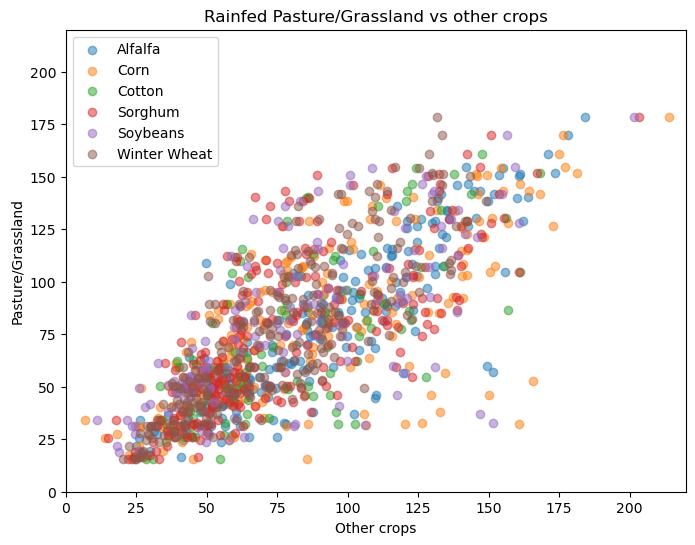

In [43]:
# scatterplot

plt.figure(figsize=(8,6))

crops = ['Alfalfa', 'Corn', 'Cotton', 'Sorghum', 'Soybeans', 'Winter Wheat']

for crop in crops:
    plt.scatter(
        df_wide[crop],
        df_wide['Pasture/Grassland'],
        alpha=0.5,
        label=crop
    )

plt.xlabel("Other crops")
plt.ylabel("Pasture/Grassland")
plt.title("Rainfed Pasture/Grassland vs other crops")
plt.xlim((0, 220))
plt.ylim((0, 220))
plt.legend()
plt.show()

### pasture vs all crops (all crops except pasture will be grouped as others)

In [7]:
# there are -9999 values in this dataframe, removing those
df_new = df[df['et'] > 0]

# mapping cdl crop names into the dataframe
df_new['crop'] = df_new['cdl'].map(usda_cdl_dict)

# filtering for major crops and
df_new = df_new[df_new['crop'].isin(['Winter Wheat', 'Pasture/Grassland', 'Sorghum', 'Cotton', 'Corn', 'Alfalfa', 'Soybeans'])]


crop_map = {'Pasture/Grassland': 'pasture', 
            'Winter Wheat': 'others', 
            'Sorghum': 'others', 
            'Cotton': 'others', 
            'Corn': 'others', 
            'Alfalfa': 'others', 
            'Soybeans': 'others'}

df_new['crop_class'] = df_new['crop'].map(crop_map)
df_new

C:\Users\fahim\AppData\Local\Temp\ipykernel_45708\414138665.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['crop'] = df_new['cdl'].map(usda_cdl_dict)


,block_id,state,year,month,rainfed,cdl,et,crop,crop_class
0,0,TX,2011,4,1.0,24.0,61.0,Winter Wheat,others
1,0,TX,2011,4,1.0,176.0,63.0,Pasture/Grassland,pasture
2,0,TX,2011,4,1.0,24.0,66.0,Winter Wheat,others
3,0,TX,2011,4,1.0,24.0,64.0,Winter Wheat,others
4,0,TX,2011,4,1.0,24.0,78.0,Winter Wheat,others
...,...,...,...,...,...,...,...,...,...
36534276,8,TX,2016,10,1.0,4.0,71.0,Sorghum,others
36534277,8,TX,2016,10,1.0,4.0,71.0,Sorghum,others
36534278,8,TX,2016,10,1.0,4.0,76.0,Sorghum,others
36534279,8,TX,2016,10,1.0,4.0,78.0,Sorghum,others


In [ ]:
df_agg = df_new.groupby(['block_id', 'state', 'year', 'month', 'crop_class']).agg(et_mean=('et', 'mean'), et_median=('et', 'median')).reset_index()

# formatting the dataframe into 'wide' format
df_wide2 = df_agg.pivot_table(
    index = ['block_id', 'state', 'year', 'month' ], # rows that are keeping the group
    columns = 'crop_class',                                # column names
    values = 'et_mean'
).reset_index()


# map state name
state_dict = {'TX': 'Texas', 'NE': 'Nebraska', 'KS': 'Kansas'}
df_wide2['state_name'] = df_wide2['state'].map(state_dict)
df_wide2['state'] = df_wide2['state_name']
df_wide2 = df_wide2.drop(columns=['state_name'])

df_wide2

In [9]:
r2_score(y_true=df_wide2['others'], y_pred=df_wide2['pasture'])

NameError: name 'df_wide2' is not defined

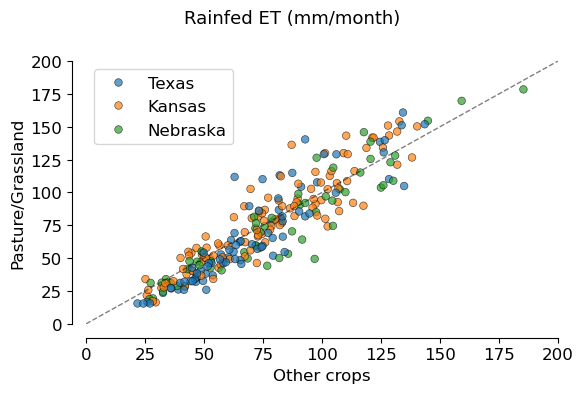

In [91]:
# scatterplot
plt.rcParams['font.size'] = 12
plt.figure(figsize=(6,4))

min_val, max_val = 0, 200

sns.scatterplot(data=df_wide2, x='others', y='pasture',  
                hue='state', palette = 'tab10', 
                alpha=0.7, edgecolors='k', s=30)         

plt.plot((min_val, max_val), (min_val, max_val), 'k--', linewidth=1, alpha=0.5)

plt.xlabel("Other crops")
plt.ylabel("Pasture/Grassland")
plt.xlim((min_val, max_val))
plt.ylim((min_val, max_val))
plt.suptitle("Rainfed ET (mm/month)", fontsize=13, y=0.98)

sns.despine(offset=10, trim=True)
plt.legend()
plt.tight_layout()

plt.savefig('plots/rainfed_ET_pasture_vs_crop.png', dpi=200)